**Imports**

In [32]:
import pandas as pd
import numpy as np
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

**1.**

In [33]:
# Define parameters
true_gmm_params = {
    'means': np.array([[0, 0], [2, 2], [1, -1], [-2, 1]]),
    'covariance_matrices': np.array([[[1, 0.5], [0.5, 1]],
                                     [[1, -0.5], [-0.5, 1]],
                                     [[2, 0.3], [0.3, 1]],
                                     [[0.5, 0], [0, 0.5]]]),
    'weights': np.array([0.3, 0.2, 0.3, 0.2])
}

num_experiments = 100
num_splits = 10
num_samples = [10, 100, 1000]
model_orders = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
frequency = np.zeros((len(num_samples), len(model_orders)))

**2.**

In [34]:
def generate_data(num_samples):
    data_components = []
    max_order = max(model_orders)
    for k in range(len(true_gmm_params['weights'])):
        samples = np.random.multivariate_normal(
            true_gmm_params['means'][k],
            true_gmm_params['covariance_matrices'][k],
            max(num_samples, max_order)  # Ensure at least max_order samples for each component
        )
        data_components.append(samples)
    data_generated = np.vstack(data_components)
    return data_generated

**3.**

In [35]:
def kfold_validation(frequency):
    freq = np.zeros((len(num_samples), len(model_orders)))  # Initialize freq array
    for exp in range(num_experiments):
        for i, n in enumerate(num_samples):
            max_order = max(model_orders)
            if n < max_order:
                raise ValueError(f"Number of samples ({n}) should be greater than or equal to the maximum model order ({max_order})")

            X = generate_data(n)
            cv_scores = np.zeros((num_splits, len(model_orders)))
            kf = KFold(n_splits=num_splits)
            for j, (train_index, test_index) in enumerate(kf.split(X)):
                X_train, X_test = X[train_index], X[test_index]
                for k, order in enumerate(model_orders):
                    gmm = GaussianMixture(n_components=order, covariance_type='full')
                    gmm.fit(X_train)
                    cv_scores[j, k] = gmm.score(X_test)
            freq[i] += np.bincount(np.argmax(cv_scores, axis=1), minlength=len(model_orders))

    frequency = freq / (num_experiments * num_splits)  # Normalize by total experiments and splits
    return frequency

**4.**

,Exp No.,No. of Samples,Order 1,Order 2,Order 3,Order 4,Order 5,Order 6,Order 7,Order 8,Order 9,Order 10
0,1,10,0.394,0.217,0.128,0.091,0.059,0.042,0.022,0.025,0.013,0.009
1,1,100,0.272,0.059,0.230,0.148,0.081,0.052,0.043,0.039,0.035,0.041
2,1,1000,0.201,0.008,0.169,0.278,0.112,0.065,0.052,0.055,0.034,0.026
3,2,10,0.394,0.217,0.128,0.091,0.059,0.042,0.022,0.025,0.013,0.009
4,2,100,0.272,0.059,0.230,0.148,0.081,0.052,0.043,0.039,0.035,0.041
...,...,...,...,...,...,...,...,...,...,...,...,...
295,99,100,0.272,0.059,0.230,0.148,0.081,0.052,0.043,0.039,0.035,0.041
296,99,1000,0.201,0.008,0.169,0.278,0.112,0.065,0.052,0.055,0.034,0.026
297,100,10,0.394,0.217,0.128,0.091,0.059,0.042,0.022,0.025,0.013,0.009
298,100,100,0.272,0.059,0.230,0.148,0.081,0.052,0.043,0.039,0.035,0.041


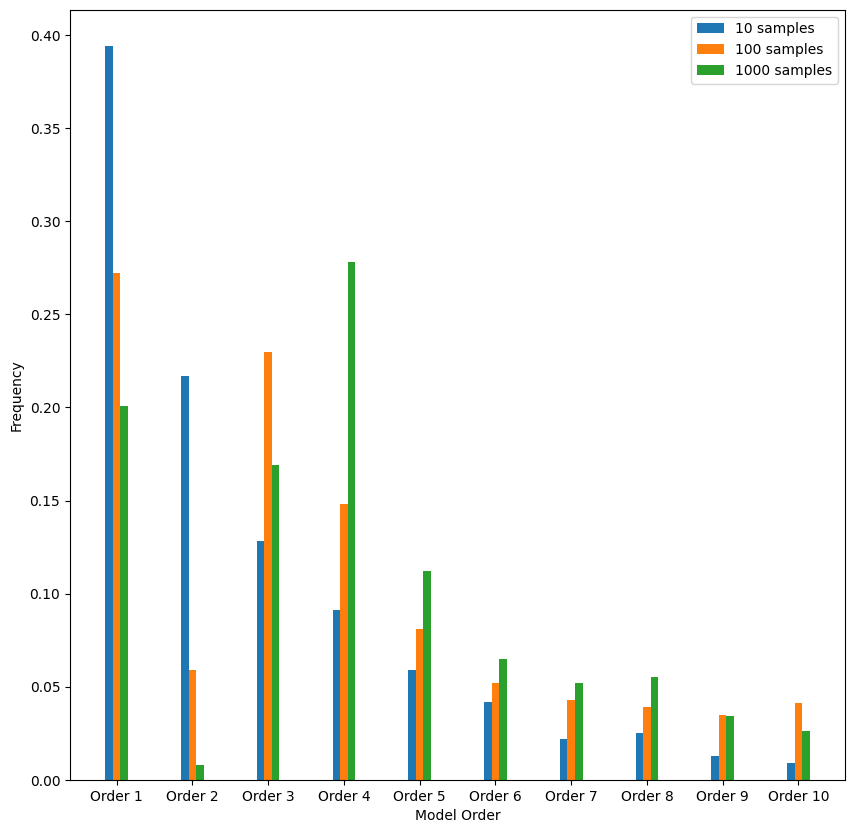

In [36]:
def display_frequency_table(frequency):
    # Create a DataFrame to display the frequency in tabular format
    columns = ['Exp No.', 'No. of Samples'] + [f'Order {order}' for order in model_orders]
    table_data = []

    for exp in range(1, num_experiments + 1):
        for i, n in enumerate(num_samples):
            row = [exp, n] + list(frequency[i])
            table_data.append(row)

    # Convert data to a DataFrame
    df = pd.DataFrame(table_data, columns=columns)

    # Display the table in a formatted way
    from IPython.display import display
    display(df)

def plot_bar(frequency):
    fig, ax = plt.subplots(figsize=(10, 10))
    width = 0.1
    x = np.arange(len(model_orders))

    for i, n in enumerate(num_samples):
        ax.bar(x + i * width, frequency[i], width, label=f"{n} samples")

    ax.set_xticks(x + width * (len(num_samples) - 1) / 2)
    ax.set_xticklabels([f"Order {order}" for order in model_orders])
    ax.set_xlabel("Model Order")
    ax.set_ylabel("Frequency")
    ax.legend()
    plt.show()

# Run the validation, display the table, and plot the bar chart
frequencies = kfold_validation(frequency)
display_frequency_table(frequencies)
plot_bar(frequencies)